In [157]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import keras

from collections import Counter

# For multiple scatter plots: 

from pandas.plotting import scatter_matrix

# For taking multiple unions:

from functools import reduce

# scikit stuff

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.base import clone

# Random forests 

from sklearn.ensemble import RandomForestClassifier

## Precision
from sklearn.metrics import precision_score
## Recall
from sklearn.metrics import recall_score

In [11]:
cc_fraud_file = pd.read_csv('C:/Users/matts/Downloads/creditcard.csv.zip')

In [12]:
df = pd.DataFrame(cc_fraud_file)

In [13]:
print(np.shape(df))

df.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [14]:
# Correlation matrix

corr_matrix = df.corr(method='pearson')

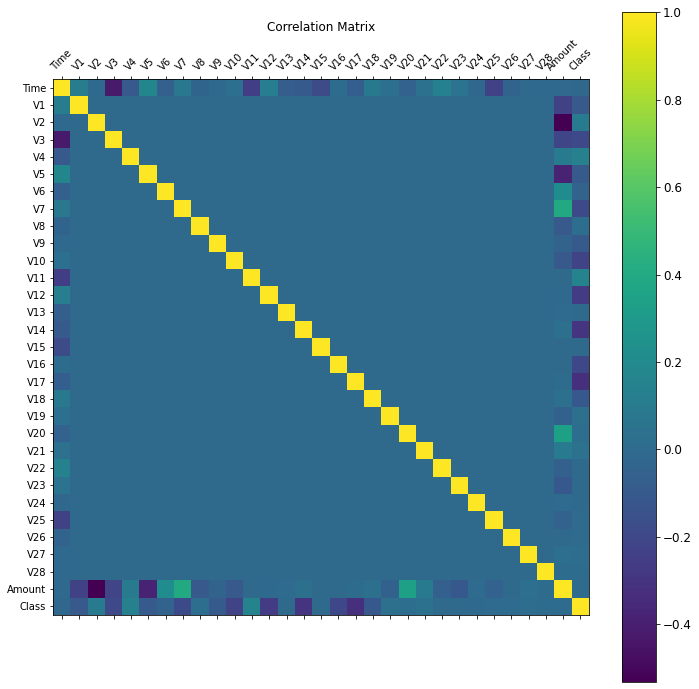

In [15]:
# Visualize the correlation matrix (code taken from 
# https://stackoverflow.com/questions/29432629/plot-correlation-matrix-using-pandas)

f = plt.figure(figsize=(12, 12))
plt.matshow(corr_matrix, fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=10, rotation=45)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=10)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=12)
plt.title('Correlation Matrix', fontsize=12);

In [16]:
plt.close()

# The V variables are independent. The only correlations are with time amount and class. Does this mean
# I should just focus on the features that have high correlations? 

In [17]:
# Pick out variables whose correlation with Time is above a certain threshold. 

time_column = np.abs(np.array(corr_matrix['Time']))

threshold = (time_column > 0.3)

corr_indices = np.where(threshold == True)[0]

print(corr_indices)

# Note that time itself is the correlation at position 0:

print(time_column[0], time_column[3])

# So we'll consider V3

[0 3]
1.0 0.41961817221152137


In [18]:
# Correlations with Class: V14, V17

class_column = np.abs(np.array(corr_matrix['Class']))

threshold = (class_column > 0.3)

corr_indices = np.where(threshold == True)[0]

corr_indices

array([14, 17, 30], dtype=int64)

In [19]:
# And for Amount...

amount_column = np.abs(np.array(corr_matrix['Amount']))

threshold = (amount_column > 0.3)

corr_indices = np.where(threshold == True)[0]

print(corr_indices)

# Position 29 corresponds to Amount

print([amount_column[k] for k in corr_indices])

# So from this we get V2, V5, V7, and V20 

[ 2  5  7 20 29]
[0.5314089393280346, 0.38635625616306496, 0.39731127818168616, 0.3394034045461662, 1.0]


In [20]:
np.shape([df['Amount']])

(1, 284807)

In [21]:
data = pd.DataFrame([df['Class'], df['Time'], df['Amount'], df['V2'], df['V3'], df['V5'], df['V7'], df['V20']])

new_df = data.transpose()

print(np.shape(new_df))

# Make a copy of relevant_data

data_copy = new_df.copy()

(284807, 8)


In [22]:
new_df.head()

,Class,Time,Amount,V2,V3,V5,V7,V20
0,0.0,0.0,149.62,-0.072781,2.536347,-0.338321,0.239599,0.251412
1,0.0,0.0,2.69,0.266151,0.166480,0.060018,-0.078803,-0.069083
2,0.0,1.0,378.66,-1.340163,1.773209,-0.503198,0.791461,0.524980
3,0.0,1.0,123.50,-0.185226,1.792993,-0.010309,0.237609,-0.208038
4,0.0,2.0,69.99,0.877737,1.548718,-0.407193,0.592941,0.408542


In [23]:
# So just how skewed is the dataset? Fraudulent transactions make up < 0.18 % of the dataset. 

class_array = list(df['Class'])
valid_trans = class_array.count(0)
fraud_trans = class_array.count(1) 

fraud_trans/valid_trans

0.0017304750013189597

In [24]:
# Create the test/train split. 

train_data = data_copy.sample(frac = .80, random_state = 614)
test_data = data_copy.drop(train_data.index)

In [25]:
train_data.head()

,Class,Time,Amount,V2,V3,V5,V7,V20
142341,0.0,84655.0,61.66,-0.641146,0.509117,-1.373556,-0.403971,-0.400919
44866,0.0,42117.0,656.49,-0.113405,-0.694370,-3.576348,2.000231,-0.241323
39170,0.0,39722.0,401.67,-1.141811,-0.207233,-0.344604,0.400823,0.531371
113763,0.0,73194.0,43.77,1.223137,-0.022789,0.202397,0.490439,-0.181692
190989,0.0,129063.0,29.40,-1.574852,-1.128711,-1.068691,-1.342566,-0.439047


In [26]:
train_data['Class']

142341    0.0
44866     0.0
39170     0.0
113763    0.0
190989    0.0
         ... 
76815     0.0
71333     0.0
7534      0.0
115509    0.0
181004    0.0
Name: Class, Length: 227846, dtype: float64

In [27]:
# Important. Needed for rescaling. 

variables = train_data.iloc[::,1::]
print(variables)

total = train_data.shape[0]

averages = 1/total * np.sum(variables)
print(averages)


variances = 1/total * np.sum((variables - averages)**2)

SDs = np.sqrt(variances)

            Time  Amount        V2        V3        V5        V7       V20
142341   84655.0   61.66 -0.641146  0.509117 -1.373556 -0.403971 -0.400919
44866    42117.0  656.49 -0.113405 -0.694370 -3.576348  2.000231 -0.241323
39170    39722.0  401.67 -1.141811 -0.207233 -0.344604  0.400823  0.531371
113763   73194.0   43.77  1.223137 -0.022789  0.202397  0.490439 -0.181692
190989  129063.0   29.40 -1.574852 -1.128711 -1.068691 -1.342566 -0.439047
...          ...     ...       ...       ...       ...       ...       ...
76815    56756.0    3.96  1.157923  1.556300  0.857027  0.812400  0.510981
71333    54259.0   50.00  0.036658 -0.463956 -0.870029 -0.192788 -0.220542
7534     10305.0    0.76  0.667139 -0.634524  0.623429  0.208048 -0.058884
115509   73889.0   29.99  2.155404 -0.767566 -1.059269 -0.927573  0.070419
181004  124784.0   85.80 -1.876930  1.526624 -0.790768 -0.728540 -0.667197

[227846 rows x 7 columns]
Time      94774.716971
Amount       88.253930
V2           -0.001303
V3  

In [28]:
# Important. These are the z-standardized variables. 

scaled_variables = (variables - averages)/SDs

scaled_variables

,Time,Amount,V2,V3,V5,V7,V20
142341,-0.213151,-0.105514,-0.387376,0.335403,-0.990189,-0.324957,-0.515083
44866,-1.109129,2.254533,-0.067869,-0.458933,-2.578340,1.607326,-0.309448
39170,-1.159574,1.243510,-0.690491,-0.137409,-0.248343,0.321864,0.686151
113763,-0.454554,-0.176494,0.741306,-0.015670,0.146029,0.393889,-0.232615
190989,0.722214,-0.233509,-0.952665,-0.745610,-0.770389,-1.079317,-0.564211
...,...,...,...,...,...,...,...
76815,-0.800788,-0.334445,0.701824,1.026574,0.618000,0.652653,0.659879
71333,-0.853382,-0.151776,0.022983,-0.306853,-0.627160,-0.155227,-0.282672
7534,-1.779184,-0.347141,0.404691,-0.419433,0.449582,0.166929,-0.074379
115509,-0.439916,-0.231168,1.305723,-0.507245,-0.763597,-0.745782,0.092224


(10000, 7)


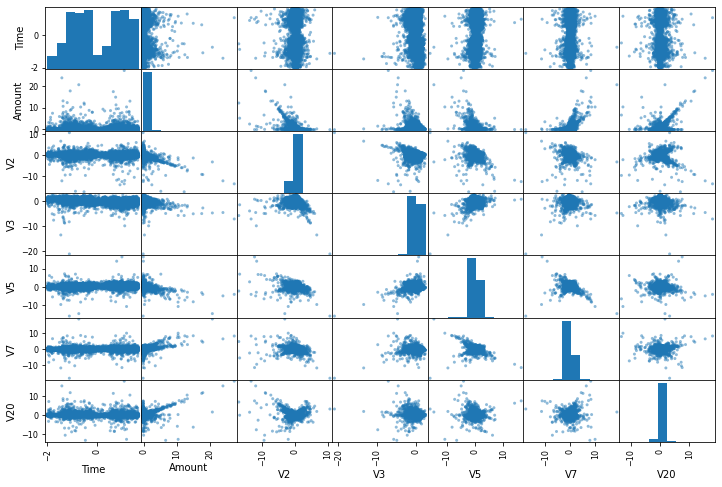

In [29]:
# Let's try going back to the scattering matrices, but this time with the normalized data. 
# Again, we'll just sample 10,000 data points. 

random_points = scaled_variables.iloc[:10000, ::]

print(np.shape(random_points))

scatter_matrix(random_points, figsize=(12,8))

plt.show()

In [30]:
plt.close()

In [32]:
# Get probability vectors. The data is already z-normalized.

feature_ps = 1/np.sqrt(2*np.pi)*np.exp(-scaled_variables**2/2)/SDs

In [33]:
feature_ps

,Time,Amount,V2,V3,V5,V7,V20
142341,0.000008,0.001574,0.224071,0.248911,0.176166,0.304144,0.450169
44866,0.000005,0.000125,0.240974,0.236994,0.010358,0.088107,0.489997
39170,0.000004,0.000731,0.190300,0.260839,0.278892,0.304449,0.406212
113763,0.000008,0.001558,0.183502,0.263281,0.284576,0.296702,0.500307
190989,0.000006,0.001540,0.153424,0.199413,0.213772,0.179081,0.438391
...,...,...,...,...,...,...,...
76815,0.000006,0.001497,0.188805,0.155465,0.237627,0.259128,0.413459
71333,0.000006,0.001565,0.241466,0.251204,0.236275,0.316795,0.493896
7534,0.000002,0.001490,0.222539,0.241141,0.259979,0.316198,0.512608
115509,0.000008,0.001541,0.102980,0.231527,0.214889,0.242792,0.511847


In [34]:
# Is there something suspicious about having a very low probability vector?

np.where(feature_ps['V2'] == min(feature_ps['V2']))

(array([70477], dtype=int64),)

In [35]:
# This V2 value is basically impossible. So why?

scaled_variables.iloc[70477]

# That corresponds to transaction number 58465 in the original dataset. 

Time      -0.976769
Amount    77.639092
V2       -38.349636
V3       -13.627447
V5       -14.903877
V7        20.057603
V20       50.794416
Name: 58465, dtype: float64

In [36]:
# These probabilities are off the charts.

feature_ps.iloc[70477]

Time       5.215005e-06
Amount     0.000000e+00
V2        1.060759e-320
V3         1.243485e-41
V5         1.678345e-49
V7         1.399784e-88
V20        0.000000e+00
Name: 58465, dtype: float64

In [37]:
# Interestingly enough, not a fraudulent transaction. 

print(df.iloc[70477]['Class'])

# So let's gather some fraudulent transactions and look at their feature probabilities (on the training data). 

fraud_indices = np.where(train_data['Class'] == 1)[0]

0.0


In [38]:
train_fraud_cases = pd.DataFrame([feature_ps.iloc[k] for k in fraud_indices])

train_fraud_cases.head()

,Time,Amount,V2,V3,V5,V7,V20
149874,0.000008,0.000200,0.034640,0.000005,0.003083,0.314293,0.285758
93486,0.000007,0.001489,0.209957,0.258038,0.280896,0.320441,0.487846
57615,0.000005,0.001490,0.095867,0.139813,0.198713,0.104268,0.495716
261925,0.000003,0.001527,0.151248,0.102076,0.166964,0.269604,0.412859
230476,0.000005,0.001582,0.057600,0.000033,0.143928,0.056999,0.466452


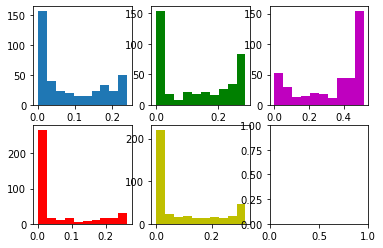

In [39]:
# Do the fraudulent probabilities look different than the valid ones?

fig, ax = plt.subplots(2, 3)

ax[0, 0].hist(train_fraud_cases['V2']) #row=0, col=0
ax[1, 0].hist(train_fraud_cases['V3'], color='r') #row=1, col=0
ax[0, 1].hist(train_fraud_cases['V5'], color='g') #row=0, col=1
ax[1, 1].hist(train_fraud_cases['V7'], color='y') #row=1, col=1
ax[0, 2].hist(train_fraud_cases['V20'], color='m') #row=0, col=2

plt.show()

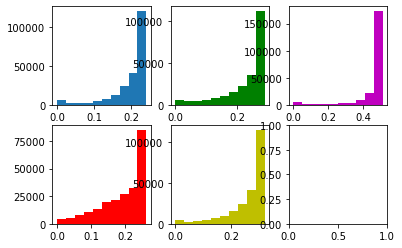

In [40]:
train_valid_cases = pd.DataFrame(feature_ps.drop(train_fraud_cases.index))

# Plots of probabilities for valid transactions. So these variables definitely have something 
# to say about whether a given transaction is false or not. Especially V3 and V7.

fig, ax = plt.subplots(2, 3)

ax[0, 0].hist(train_valid_cases['V2']) #row=0, col=0
ax[1, 0].hist(train_valid_cases['V3'], color='r') #row=1, col=0
ax[0, 1].hist(train_valid_cases['V5'], color='g') #row=0, col=1
ax[1, 1].hist(train_valid_cases['V7'], color='y') #row=1, col=1
ax[0, 2].hist(train_valid_cases['V20'], color='m') #row=0, col=2

plt.show()

In [41]:
# Let's split according to V2, V3, V5, and V7 separately. Adjust epsilon p_j >= epsilon until we have 50/50 split.
# Let's only drop V3 and V7.

#V2_indices = np.where(feature_ps['V2'] >= 0.1)[0]
V3_indices = np.where(feature_ps['V3'] >= 0.07)[0]
#V5_indices = np.where(feature_ps['V5'] >= 0.1)[0]
V7_indices = np.where(feature_ps['V7'] >= 0.17)[0]

# Now take the union. 

drop_indices = reduce(np.union1d, (V3_indices, V7_indices))
#drop_indices = V3_indices

a = len(drop_indices)
b = len(feature_ps)
print(a/b)

0.9829446204892779


In [203]:
# Since V14 and V17 are correlated with Class, let's plot them. 

X = df.iloc[:, [14, 17]]
y = df.iloc[:, 30]

# The average of V14 and V17 are already 0 but it doesn't seem like the SD is normalized. 

X = np.array(X)

SDs = np.sum(X**2, axis=0)/np.shape(X)[0]

norm_X = X/SDs

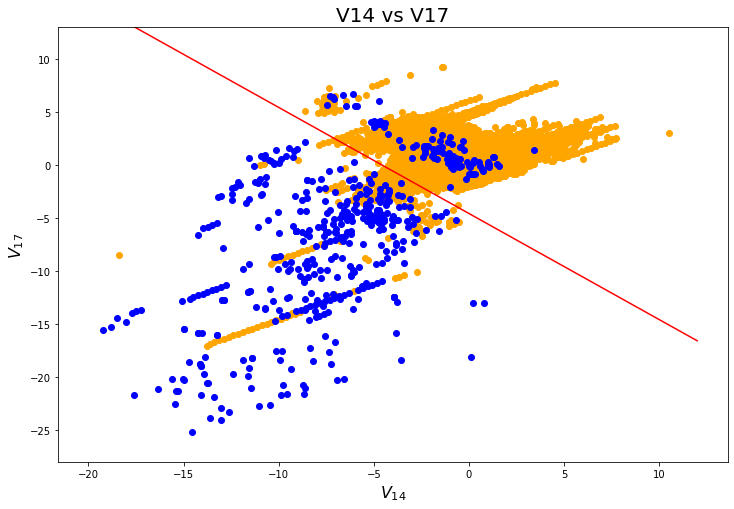

In [204]:
# Scatter plot of 14 against 17 labeling the data valid/fraud. 
# Why are there these lines in the data? 
# I'm going to adjust the line's constant until I have roughly a 50/50 split.

plt.figure(figsize=(12,8))

x_points = np.array([-20, 12])
z = -1*x_points - 4.56

plt.plot(x_points, z, color='r')

plt.scatter(X[y == 0, 0], X[y == 0, 1], color='orange', label='0')
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', label='1')

plt.xlabel("$V_{14}$",fontsize=16)
plt.ylabel("$V_{17}$",fontsize=16)
plt.title("V14 vs V17",fontsize = 20)

plt.ylim(np.array([-28, 13]))

plt.show()

In [205]:
plt.close()

In [206]:
# I want to train the model on different regions where I think the behavior is different.
# The region where the frauds are mixed up heavily with the valid might be trouble. 
# The bottom region will correspond to x + y <= -4. 

indices = []

for k in range(np.shape(X)[0]):
    if  X[k][0] + X[k][1] <= -4.56:
        indices.append(k)
        
print(len(indices))

X_region = X[indices]
y_region = y[indices]

print(len(y_region))

787
787


In [49]:
# 

num_fraud = np.sum(y_region)

print(f'Number of fraudulent transactions in Region 1 is {num_fraud}')

prop = np.sum(y_region)/len(y_region)

print(f'Proportion of fraudulent transcations in region 1 is {prop}')

Number of fraudulent transactions in Region 1 is 394
Proportion of fraudulent transcations in region 1 is 0.5006353240152478


In [52]:
# RF model on region 1

X_1 = df.iloc[indices, :-1].copy()
y_1 = df['Class'].iloc[indices].copy()

X_train, X_test, y_train, y_test = train_test_split(X_1, y_1,
                                                 test_size = .25,
                                                 random_state = 614,
                                                 shuffle = True,
                                                 stratify = y_1)


In [57]:
# Perform CV to determine the optimal max_depth. 

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=440)

X_train_copy = X_train.copy() # Should we keep all the columns?

# Let's consider n=20 as the maximum max_depth. 

n=20

precs = np.zeros((5,n))
recs = np.zeros((5,n)) 

# Make a RF for every value of max_depth up to n


for j in range(1, n+1):
    print(j)
    
    rf = RandomForestClassifier(n_estimators=500, max_depth=j, random_state=440)
    
    i = 0
    for train_index, test_index in kfold.split(X_train_copy, y_train):
        X_train_train, X_train_test = X_train_copy.iloc[train_index], X_train_copy.iloc[test_index]
        y_train_train, y_train_test = y_train.iloc[train_index], y_train.iloc[test_index]
        
        rf_clone = clone(rf)
        rf_clone.fit(X_train_train, y_train_train)
        
        y_pred = rf_clone.predict(X_train_test)
        precs[i,j-1] = precision_score(y_train_test, y_pred)
        recs[i,j-1] = recall_score(y_train_test, y_pred)
        i += 1
    

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


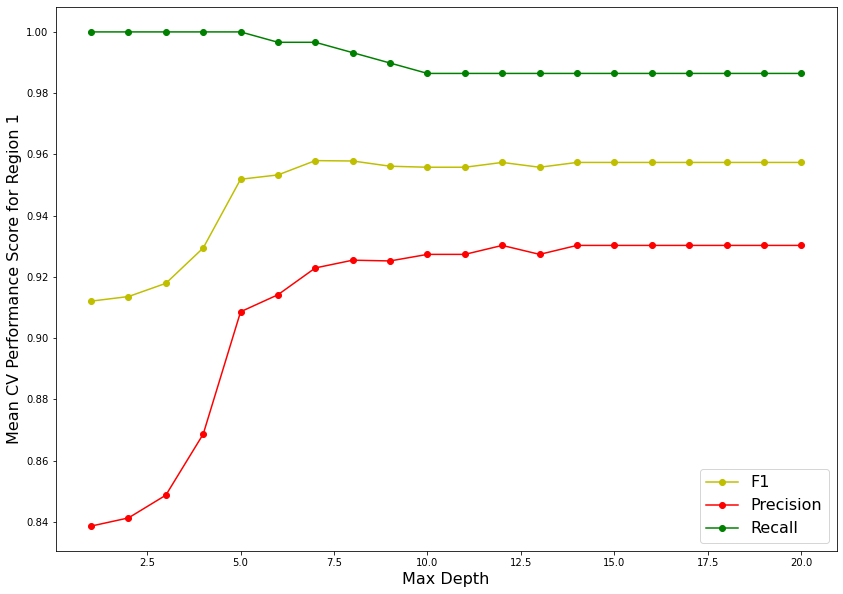

In [61]:
## Plot that mean cv measure against max_depth

F1 = 2*precs*recs/(precs+recs)

## Sample Answer
plt.figure(figsize=(14,10))

plt.plot(range(1,n+1), np.mean(F1,axis=0),'y-o', label="F1")
plt.plot(range(1,n+1), np.mean(precs,axis=0),'r-o', label="Precision")
plt.plot(range(1,n+1), np.mean(recs,axis=0),'g-o', label="Recall")

plt.ylabel("Mean CV Performance Score for Region 1",fontsize=16)
plt.xlabel("Max Depth",fontsize=16)

plt.legend(fontsize=16)

plt.show()

In [91]:
# Recall here is more important, so maybe we should go with max_depth = 5 or 6. 
rf = RandomForestClassifier(n_estimators=500, max_depth=6, random_state=440)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [92]:
# The training on region 1 (these are backwards)

print(recall_score(y_pred, y_test))
print(precision_score(y_pred, y_test))

0.9238095238095239
0.9797979797979798


In [302]:
# Let's try out the prediction on the larger data set to see how it does. 

fraud_list = df['Class'].loc[lambda s: s == 1]
fraud_data = df.iloc[fraud_list.index]
valid_data = df.drop(fraud_data.index)

valid_sample = valid_data.sample(492, random_state=42)

balanced_data = pd.concat([fraud_data, valid_sample])

# Make a copy and shuffle

balanced_copy = balanced_data.copy()
balanced_copy = balanced_copy.sample(frac=1, random_state=21)


In [201]:
# Now the predictions

X = balanced_copy.iloc[:, :-1]
y = pd.DataFrame(balanced_copy['Class'])

# Just a check
print(np.sum(y))

y_pred = rf.predict(X)

Class    492
dtype: int64


In [199]:
# Metrics

print(recall_score(y, y_pred))
print(precision_score(y, y_pred))

0.8252032520325203
1.0


In [194]:
# It's underclassifying. Reason: it's good at detecting fraud cases in region 1, but not region 2.
# So we need another classifier for region 2. 

np.unique(y_pred, return_counts=True)

# Or the pandas way

y_pred = pd.DataFrame(y_pred)

y_pred.value_counts()

0    578
1    406
dtype: int64

In [388]:
# So let's work on region 2. Make sure to rerun the earlier blocks defining indices. 
# Problem is, this region is even more imbalanced. But let's see where it goes. 
# I feel like a 50/50 split is not a good idea, so let's do about 70/30. 

X_2 = df.drop(X_1.index)
y_2 = df['Class'].drop(X_1.index)



In [306]:
len(X_2) + len(X_1) == len(df)

True

In [307]:
print(y_2.value_counts())

98/283922

0    283922
1        98
Name: Class, dtype: int64


0.00034516522143405586

In [380]:
# Similar to before

fraud_list_2 = fraud_list.copy()
fraud_data = df.iloc[fraud_list.index]

fraud_data_2 = pd.merge(X_2, fraud_data) # This renames the indices!!
valid_data_2 = pd.merge(X_2, valid_data)

# Let's randomly sample 98 valid transactions to get a 50/50 split. 

valid_sample_2 = valid_data_2.sample(98, random_state=42)

balanced_data = pd.concat([fraud_data_2, valid_sample_2])

# Make a copy and shuffle

balanced_copy = balanced_data.copy()
balanced_copy = balanced_copy.sample(frac=1, random_state=21)

In [381]:
# Check to make sure it's working. 
print(valid_data_2['Class'].value_counts())
print(fraud_data_2['Class'].value_counts())
balanced_copy['Class'].value_counts()

0    287320
Name: Class, dtype: int64
1    98
Name: Class, dtype: int64


1    98
0    98
Name: Class, dtype: int64

In [382]:
X_new = balanced_copy.iloc[:, :-1]
y_new = balanced_copy['Class']

X_train, X_test, y_train, y_test = train_test_split(X_new, y_new,
                                                 test_size = .25,
                                                 random_state = 614,
                                                 shuffle = True,
                                                 stratify = y_new)

In [383]:
# Same cv stuff on region 2.

# Perform CV to determine the optimal max_depth. 

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=440)

X_train_copy = X_train.copy() # Should we keep all the columns?

# Let's consider n=20 as the maximum max_depth. 

n=20

precs = np.zeros((5,n))
recs = np.zeros((5,n)) 

# Make a RF for every value of max_depth up to n


for j in range(1, n+1):
    print(j)
    
    rf = RandomForestClassifier(n_estimators=500, max_depth=j, random_state=440)
    
    i = 0
    for train_index, test_index in kfold.split(X_train_copy, y_train):
        X_train_train, X_train_test = X_train_copy.iloc[train_index], X_train_copy.iloc[test_index]
        y_train_train, y_train_test = y_train.iloc[train_index], y_train.iloc[test_index]
        
        rf_clone = clone(rf)
        rf_clone.fit(X_train_train, y_train_train)
        
        y_pred = rf_clone.predict(X_train_test)
        precs[i,j-1] = precision_score(y_train_test, y_pred)
        recs[i,j-1] = recall_score(y_train_test, y_pred)
        i += 1

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


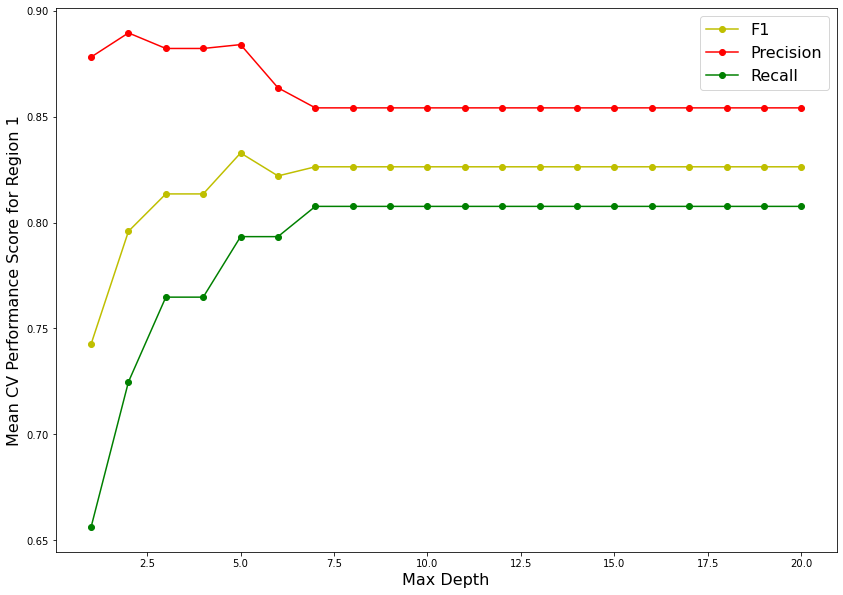

In [384]:
## Plot that mean cv measure against max_depth

F1 = 2*precs*recs/(precs+recs)

## Sample Answer
plt.figure(figsize=(14,10))

plt.plot(range(1,n+1), np.mean(F1,axis=0),'y-o', label="F1")
plt.plot(range(1,n+1), np.mean(precs,axis=0),'r-o', label="Precision")
plt.plot(range(1,n+1), np.mean(recs,axis=0),'g-o', label="Recall")

plt.ylabel("Mean CV Performance Score for Region 1",fontsize=16)
plt.xlabel("Max Depth",fontsize=16)

plt.legend(fontsize=16)

plt.show()

In [385]:
# Let's set max_depth to 7 here. 

rf_2 = RandomForestClassifier(n_estimators=500, max_depth=6, random_state=440)

rf_2.fit(X_train, y_train)
y_pred = rf_2.predict(X_test)

In [387]:
print(recall_score(y_test, y_pred))
print(precision_score(y_test, y_pred))

0.8
0.9523809523809523


In [390]:
# Now we combine rf and rf_2 into a single predictor. Maybe we can expect the recall to be

exp_rec = .75*.98 + .25*.8
exp_rec

0.935